
<h1><center> <font color='black'>  Network Science (LTAT.02.011) - Homework - 02  (Total points - 15)</font></center></h1>
<h2><center> <font color='black'> Introduction to Network Analysis</font></center></h3>
<h2><center> <font color='black'> University of Tartu</font></center></h3>


================================================================================================================

# Homework instructions


- Please provide the names and student IDs of the team-members (Maximum 2 person) in the field "Team mates" below. If you are not working in a team please insert only your name and student ID. 

- ONLY one of the teammates should submit the homework. We will grade the homework and the marks and feedback is applied for both the team members. So please communicate with your team member about marks and feedback if you are submit the homework.


- The accepted submission format is .ipynb file. Please upload the file on moodle.

- The submission will automatically close on **<font color='red'>7th April 2021 at 23:59 pm</font>**, so please make sure you have enough time to submit the homework. 

- You do not necessarily need to work on Colab. Especially as the size and the complexity of datasets will increase through the course, you can install jupyter notebooks locally and work from there.

- If you do not understand what a question is asking for, please ask in Moodle. 

- Please Click on "**Restart and Run All**" before uploading the '.ipynb' file.

- Plagiarism is <font color='red'>**PROHIBITED**</font>. Any form of plagiarism will be dealt according to the university policy (https://www.ut.ee/en/current-students/academic-fraud).



**<h2><font color='red'>Student info:</font></h2>**


<font color='red'>Full name: </font> Hannula-Katrin Pandis, Canberk Özen

<font color='red'>Student ID: </font> B04920, B97964



================================================================================================================

# 1. Link prediction using varoius scoring method (5 points)

<font color='red'>At the start, we have provided the necessary codes. Please run all of these cells before starting tasks 1.1 through 1.3.</font>

In [ ]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
# load nodes details
with open("fb-pages-food.nodes") as f:
    fb_nodes = f.read().splitlines() 

# load edges (or links)
with open("fb-pages-food.edges") as f:
    fb_links = f.read().splitlines() 

len(fb_nodes), len(fb_links)

(621, 2102)

In [ ]:
# captture nodes in 2 separate lists
node_list_1 = []
node_list_2 = []

for i in tqdm(fb_links):
  node_list_1.append(i.split(',')[0])
  node_list_2.append(i.split(',')[1])

fb_df = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2})
fb_df.head()

100%|██████████| 2102/2102 [00:00<00:00, 522671.75it/s]


,node_1,node_2
0,0,276
1,0,58
2,0,132
3,0,603
4,0,398


In [ ]:
# create graph
G = nx.from_pandas_edgelist(fb_df, "node_1", "node_2", create_using=nx.Graph())

# combine all nodes in a list
node_list = node_list_1 + node_list_2

# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))

# build adjacency matrix
adj_G = nx.to_numpy_matrix(G, nodelist = node_list)

# get unconnected node-pairs
all_unconnected_pairs = []

# traverse adjacency matrix
offset = 0
for i in tqdm(range(adj_G.shape[0])):
  for j in range(offset,adj_G.shape[1]):
    if i != j:
      if nx.shortest_path_length(G, str(i), str(j)) <=2:
        if adj_G[i,j] == 0:
          all_unconnected_pairs.append([node_list[i],node_list[j]])

  offset = offset + 1


node_1_unlinked = [i[0] for i in all_unconnected_pairs]
node_2_unlinked = [i[1] for i in all_unconnected_pairs]

data = pd.DataFrame({'node_1':node_1_unlinked, 
                     'node_2':node_2_unlinked})

# add target variable 'link'
data['link'] = 0


initial_node_count = len(G.nodes)

fb_df_temp = fb_df.copy()

# empty list to store removable links
omissible_links_index = []

for i in tqdm(fb_df.index.values):
  
  # remove a node pair and build a new graph
  G_temp = nx.from_pandas_edgelist(fb_df_temp.drop(index = i), "node_1", "node_2", create_using=nx.Graph())
  
  # check there is no spliting of graph and number of nodes is same
  if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
    omissible_links_index.append(i)
    fb_df_temp = fb_df_temp.drop(index = i)
    

# create dataframe of removable edges
fb_df_ghost = fb_df.loc[omissible_links_index]

# add the target variable 'link'
fb_df_ghost['link'] = 1

data = data.append(fb_df_ghost[['node_1', 'node_2', 'link']], ignore_index=True)

# drop removable edges
fb_df_partial = fb_df.drop(index=fb_df_ghost.index.values)

# build graph
G_data = nx.from_pandas_edgelist(fb_df_partial, "node_1", "node_2", create_using=nx.Graph())

100%|██████████| 2102/2102 [00:11<00:00, 187.43it/s]


In [ ]:
data.head()

,node_1,node_2,link
0,0,22,0
1,0,526,0
2,0,36,0
3,0,54,0
4,0,56,0


## **1.1. Calculate all the scores for every pair in "data" using graph "G_data". (4 points)**

<font color='red'>You can add extra cells if required.</font>

In [ ]:
# 1. Number of common neighbors
neighbours = []
for i in range(len(data)):
  neighbours.append(len(list(nx.common_neighbors(G_data,data.node_1[i],data.node_2[i]))))

data['common_neighbor'] = neighbours

In [ ]:
# 2. Jaccard coefficient
jaccard = []
for i in range(len(data)):
  jaccard.append(list(nx.jaccard_coefficient(G_data, ebunch=[(data.node_1[i],data.node_2[i])]))[0][2])

data['jaccard_similarity'] = jaccard

In [ ]:
# 3. Adamic/Adar
adamic_adar = []
for i in range(0,len(data)):
  if data.node_1[i] == data.node_2[i]:
    adamic_adar.append(0)
  else:
    adamic_adar.append(list(nx.adamic_adar_index(G_data, ebunch=[(data.node_1[i],data.node_2[i])]))[0][2])
    #print(list(nx.adamic_adar_index(G_data, ebunch=[(data.node_1[i],data.node_2[i])])))

data['adamic_adar_index'] = adamic_adar

In [ ]:
# 4. Shortest path
def compute_shortest_path_length(u,v):
    try:
        if G_data.has_edge(u,v):
            return -1
        else:
            p= nx.shortest_path_length(G_data,source=u,target=v)
        return p
    except:
        return -1

shortest_path = []
for i in range(len(data)):
  shortest_path.append(compute_shortest_path_length(data.node_1[i],data.node_2[i]))

data['shortest_path'] = shortest_path

In [ ]:
# 5. Katz score

from numpy.linalg import inv
L = nx.normalized_laplacian_matrix(G_data)
e = (np.linalg.eigvals(L.A)).real

beta = 1/max(e)
I = np.identity(len(G_data.nodes))
katz = inv(I - nx.to_numpy_array(G_data)*beta) - I

katz_score = []

for i in range(len(data)):
  katz_score.append(katz[int(data.node_1[i])][int(data.node_2[i])])

data['katz_score'] = katz_score

In [ ]:
# 6. Preferrential attachment
pref = []
for i in range(len(data)):
  pref.append(list(nx.preferential_attachment(G_data, ebunch=[(data.node_1[i],data.node_2[i])]))[0][2])

data['preferrential_attachment'] = pref

In [ ]:
# 7. Hitting times
dist = []
for i in range(len(data)):
  if data.node_1[i] == data.node_2[i]:
    dist.append(0)
    #print("added 0")
  else:
    asp = nx.all_simple_paths(G_data, data.node_1[i], data.node_2[i])
    for path in asp:
      #print(len(path))
      dist.append(len(path))
      
data['hitting_time'] = dist

In [ ]:
# 8. SimRank
sim = nx.simrank_similarity(G_data)
sim_list = [[sim[u][v] for v in sorted(sim[u])] for u in sorted(sim)]
simrank = np.array(sim_list)

sim_rank = []
for i in range(len(data)):
  a = int(data.node_1[i])
  b = int(data.node_2[i])
  sim_rank.append(simrank[a][b])

data['simrank'] = sim_rank

In [ ]:
# 8. SimRank

################# THIS RUNS FOR WAY TOO LONG! approximately 8sec per pair with max_iterations=4 and takes too much time to get the results!
## even running with max_iteration=1 it would take 9,5hrs to complete. We have added runtime to GPU but it does not help

#sim = []
#for i in range(len(data)):
#  sim.append(nx.simrank_similarity(G_data, source=data.node_1[i], target=data.node_2[i], max_iterations=4))
  #print(i, "and value is " , sim[i])

#data['simrank'] = sim

## **1.2. Create features and target value for the model. Split dataset into training and testing. (0.5 point)**

In [ ]:
'''
Hint: Remove columns node_1,	node_2 and link while creating "x" from data.
'''

data_new = data.drop(columns = ['node_1', 'node_2', 'link'], axis = 1)

x = data_new
y = data['link']

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, 
                                                test_size = 0.3, 
                                                random_state = 35)

## **1.3. Apply logistic regression model and report auc roc score. (0.5 point)**

In [ ]:
lr = LogisticRegression(class_weight="balanced")

#TODO
lr.fit(xtrain, ytrain)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
predictions = lr.predict_proba(xtest)

#TODO
roc_auc_score(ytest, predictions[:,1])

0.8472854045673684

================================================================================================================

##2. Node2Vec (10 points)
documentation for reference - https://github.com/eliorc/node2vec  

# Dataset details:
**In this homework, the dataset consists of network of Wikipedia articles. That is, nodes consists of Wikipedia articles and edges are the connections between the two articles if one article has hyper-links of other article. Following are the steps to generate network dataset** - <br>
1. You are required to generate this type of network/graph from this [Website](https://densitydesign.github.io/strumentalia-seealsology/) (You can read more about its working on their webpage). 
2. After clicking this website link, you have to enter this URL https://en.wikipedia.org/wiki/Network_science in the text box shown on the webpage "Paste your list of wikipedia articles here" and put 2 in the "Distance" box if not already there. 
3. Then, click on "Start Crawling". 
4. Once the crawling is completed, you can download the "TSV" file in your local machine. This "TSV" file will be your edgelist, that is, each row consists of "source", "target" and "level"/"depth" information. <br>
Note: You can also see how the graph looks likes by scrolling down that website's page.

# Libraries

In [ ]:
# Importing required libraries (install other libraries if needed)
!pip install node2vec
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from node2vec import Node2Vec
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

  Created wheel for node2vec: filename=node2vec-0.4.2-cp37-none-any.whl size=5859 sha256=66f10f255e360b7b5280aac818f106d50171872e9b322eeaefb863dad69b7847
  Stored in directory: /root/.cache/pip/wheels/2a/d6/34/7f62d314dfad813eea2a41c5e4a9dedec1f52e335688c8f7ad
Successfully built node2vec


# Reading the dataset

In [ ]:
# import the "TSV" data file where edge list is stored (separated by tab) give the name of your file as 'network_science'
edges_list = pd.read_csv(r"network_science.tsv", sep = '\t')

In [ ]:
# check first five rows of the dataframe (will use "depth" column later)
edges_list.head()

,source,target,depth
0,network science,cascading failure,1
1,network science,climate as complex networks,1
2,network science,collaborative innovation network,1
3,network science,communicative ecology,1
4,network science,complex network,1


In [ ]:
# check shape of the dataframe
edges_list.shape

(283, 3)

# 2.1 Graph creation (1 point)

**2.1.1 Create undirected and unweighted graph using the edges_list dataset and check the basic properties of the graph such as number of nodes, average node degree, etc. Leave the "depth" column for now.  (0.50 points)** <br>
<font color='red'>How you should answer the following questions: In the `#TODO` cell you have to write the code representing your solution.</font>

In [ ]:
G = nx.from_pandas_edgelist(edges_list, source='source', target='target', edge_attr=None)

In [ ]:
# basic info of graph
print("Graph has", nx.number_of_nodes(G), "nodes")
print("Graph has", nx.number_of_edges(G), "edges")
print("Graph degree is", np.array([d for n, d in G.degree()]).sum()/nx.number_of_nodes(G))
print("Graph average shortest path length is", nx.average_shortest_path_length(G))
print("Graph diameter is", nx.diameter(G))
print("Graph transitivity is", nx.transitivity(G))
print("Graph average clustering is", nx.average_clustering(G))
print("Graph edge density is", nx.classes.function.density(G))
print("Graph has", np.array(list(nx.triangles(G).values())).sum(), "total triangles")
print("Graph has", nx.algorithms.components.number_connected_components(G), "connected components")

Graph has 255 nodes
Graph has 276 edges
Graph degree is 2.164705882352941
Graph average shortest path length is 3.536946117029489
Graph diameter is 4
Graph transitivity is 0.013416815742397137
Graph average clustering is 0.012524571130926984
Graph edge density is 0.008522464103751737
Graph has 45 total triangles
Graph has 1 connected components


**2.1.2 Plot the network graph (0.50 points)** <br>
<font color='red'>In the `Your answer` cell write which type of graph (example line graph) it is and explain in one line about the type of graph in your own words. It does not have to be a full sentence.</font><br>
<font color='red'>Write your observation in the `Your answer` cell.</font>

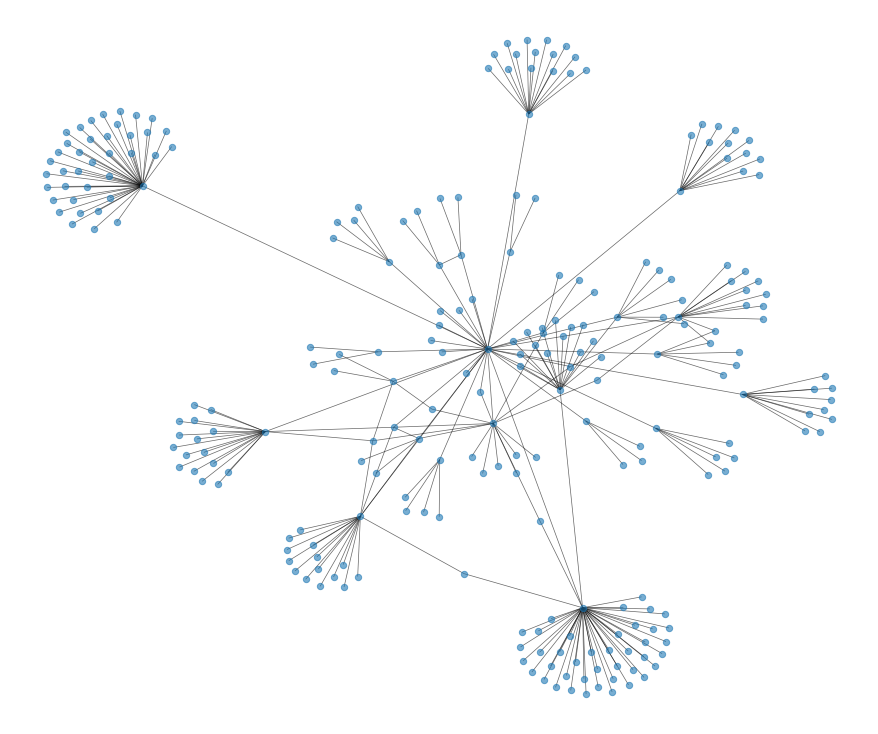

In [ ]:
plt.figure(3,figsize=(12,10))
nx.draw(G, node_size = 40, alpha = 0.6, width = 0.7, with_labels=False)

**<font color='red'>Your answer:</font>** Looks like this is a Barabasi Albert graph with m0 =1. Such models have a small clustering coefficient, short path length and their degree distribution follows power-law. It comes as no surprise since they fit into explaining internet well.

# 2.2 Node2Vec Embeddings (6 points)

**2.2.1. For the Graph G, created in task 2.1.1, use  Node2Vec for creating embeddings, with parameters - number of dimensions as 32, walk length as 10 and total number of walks as 50 and workers as 1 (0.50 point).**

<font color='red'>How you should answer the following questions. In the `#TODO` cell you have to write the code representing your solution. .</font>

In [ ]:
# Precompute probabilities and generate walks**
node2vec = Node2Vec(G, dimensions=32, walk_length=10, num_walks=50, workers = 1)

Generating walks (CPU: 1):   0%|          | 0/50 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:08<00:00,  5.96it/s]


**2.2.2 For the Graph G, created in task 2.1.1, use  Node2Vec for creating embeddings, with parameters - p > 1 (anay value greater than 1) and q < 1 (anay value less than 1), number of dimensions as 32, walk length as 10 and total number of walks as 50 and workers as 1 (0.50 point).**

<font color='red'>How you should answer the following questions. In the `#TODO` cell you have to write the code representing your solution. .</font>

In [ ]:
node2vec_modified_pq = Node2Vec(G, dimensions=32, walk_length=10, num_walks=50, workers = 1, p = 10, q = 0.25)

Generating walks (CPU: 1):   4%|▍         | 2/50 [00:00<00:04, 10.74it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:08<00:00,  5.88it/s]


**2.2.3 For the Graph G, created in task 2.1.1, use  Node2Vec for creating embeddings, with parameters - p < 1 (anay value less than 1) and q > 1 (anay value greater than 1), number of dimensions as 32, walk length as 10 and total number of walks as 50 and workers as 1 (0.50 point).**

<font color='red'>How you should answer the following questions. In the `#TODO` cell you have to write the code representing your solution. .</font>

In [ ]:
node2vec_modified_pq_again = Node2Vec(G, dimensions=32, walk_length=50, num_walks=20, workers = 1, p = 0.25, q = 10)

Generating walks (CPU: 1):   0%|          | 0/20 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


**2.2.4 When Node2vec and DeepWalk is considered to be similar? Also, what must have happened in terms of the structure of the embeddings when "p" and "q" parameters of Node2Vec are changed just like you did in all the three cases mentioned above? (0.50 point)** <br>
<font color='red'>Write your observation in the `Your answer` cell.</font>

**<font color='red'>Your answer:</font>** Node2Vec and Deepwalk are similar if there is no parameters p and q used in Node2Vec, as then the probability to go randomly to next node (or back to where you just came from) is the same. Parameter "p" controls the probability to go back to the node where one just came from, parameter "q" controls the probability to go exploring undiscovered parts of the graph. When "p" is high, it means that the probability to go back to the visited node is really high, and when "q" is high, then the walking continues to undiscovered nodes.

This means that in 2.2.2, when our p value is high and q is low, we will be exploring the micro-neighborhoods more and create the node embeddings according to that. In 2.2.3, we will be exploring macro-neighborhoods, so nodes that are far away from each other may have high embedding similarity.

**2.2.5 Embed the nodes using "fit" function of Node2Vec created in 2.2.1. Keep the "window_count" paramater as 10 and "min_count" as 1. (0.50 point).**

<font color='red'>How you should answer the following questions. First, in the `#TODO` cell you have to write the code representing your solution. .</font>

In [ ]:
# Embed nodes
model = node2vec.fit(window=10, min_count=1)

**2.2.6 Get the node embedding of 'network science' node. (0.50 point).**

<font color='red'>How you should answer the following questions. In the `#TODO` cell you have to write the code representing your solution. .</font>

In [ ]:
# Get the vector of node 'network science'
model.wv.get_vector('network science') #the current way

# or the more intuitive dictionary based way
# model['network science']

array([ 0.38573766, -0.22229064, -0.08405595,  0.15671277, -0.24604909,
       -0.03691706, -0.1599852 ,  0.5977866 , -0.01064547, -0.6850973 ,
       -0.38410935, -0.2659978 ,  0.3529034 ,  0.04560275,  0.20285134,
        0.13524461,  0.64052385,  0.17537549,  0.22426182,  0.00141747,
       -0.36675054, -0.09077865, -0.29086295, -0.2457027 , -0.31101397,
       -0.3454166 , -0.28388467, -0.08071749,  0.41275284,  0.01518169,
       -0.4268977 , -0.4006842 ], dtype=float32)

**2.2.7 Check which are the similar nodes with respect to 'network science' node. (0.50 point).**

<font color='red'>How you should answer the following questions. In the `#TODO` cell you have to write the code representing your solution. .</font>

In [ ]:
# most similar nodes to node 'network science'
for node, _ in model.most_similar('network science'):
    print((node, _))

('rumor spread in social network', 0.7538527250289917)
('network formation', 0.697803795337677)
('communicative ecology', 0.6688809394836426)
('networks in labor economics', 0.6478724479675293)
('non-linear preferential attachment', 0.6460323333740234)
('network theory in risk assessment', 0.620253324508667)
('immune network theory', 0.5827874541282654)
('dual-phase evolution', 0.5736922025680542)
('service network', 0.5576959848403931)
('scale-free networks', 0.5477418899536133)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


**2.2.8 According to you, which node(s) have given you the correct embedding (Hint: this can be verified by looking at the network graph). (0.75 point).**

<font color='red'>How you should answer the following questions. First, in the `#TODO` cell you have to write the code representing your solution. .</font>
<font color='red'>Write your observation in the `Your answer` cell.</font>**

**<font color='red'>Your answer:</font>** 
Answer is based on following results (last results will differ when we do Restart Kernel and Run All):
* ('network theory in risk assessment', 0.7214217185974121)
* ('rumor spread in social network', 0.7039720416069031)
* ('immune network theory', 0.7001493573188782)
* ('network formation', 0.6961420774459839)
* ('non-linear preferential attachment', 0.6949734687805176)
* ('networks in labor economics', 0.6913201808929443)
* ('communicative ecology', 0.6845932006835938)
* ('structural cut-off', 0.5677346587181091)
* ('scale-free networks', 0.5660696625709534)
* ('countability', 0.5579176545143127)

We checked the network through https://densitydesign.github.io/strumentalia-seealsology/, and we can see that the most similar nodes returned by node2vec are close to our node 'network science' in the graph.

We can safely say that higher-dimensional algebra should be coming after dual-phase evolution since the latter node is much closer to network science node in the visual. Network formation was given a quite low similarity score so that's a bit abnormal as well. Taking the website network as ground truth - 'structural cut-off' is further than 'scale-free network', yet smilarity is bigger, so that's incorrect. Also, 'countability' is really far from 'network science', so the embedding cannot be correct. 

In short - correct embeddings are everything except 'structural cut-off' and 'countability'.

**2.2.9 According to you, which node(s) have given you the incorrect embedding (Hint: this can be verified by looking at the network graph). (0.75 point).**

<font color='red'>How you should answer the following questions. First, in the `#TODO` cell you have to write the code representing your solution. .</font>
<font color='red'>Write your observation in the `Your answer` cell.</font>**

**<font color='red'>Your answer:</font>** Long answer in 2.2.8 - short: incorrect embeddings are for 'structural cut-off' and 'countability'.

**2.2.10 Save the node embeddings (0.25 point).**

<font color='red'>How you should answer the following questions. In the `#TODO` cell you have to write the code representing your solution. .</font>

In [ ]:
# save the node embeddings
#TODO
model.wv.save_word2vec_format('embedding.csv')
model.save('model')

**2.2.11 Retrieve all the nodes' embeddings to be used in classification task (0.50 point).**

<font color='red'>How you should answer the following questions. In the `#TODO` cell you have to write the code representing your solution. .</font>

In [ ]:
# Retrieve node embeddings
node_ids = model.wv.index2word   # list of node IDs
node_embeddings = model.wv.vectors

**2.2.12 Can you apply node2vec on Dynamic Graphs (Dynamic Graphs are those graphs wherein either the nodes or edges change over time) (0.25 point).**

<font color='red'>Write your answer in the `Your answer` cell.</font>

**<font color='red'>Your answer:</font>** No, Node2vec cannot be applied to Dynamic Graphs, since it's meant for static graphs. A dynamic embedding method, dynnode2vec, based on the node2vec exists, than can be applied to Dynamic Graphs.

The stochastic grad descent will not work due to the permanent shifts in micro and macro neighborhoods. In this case you cannot optimize the embedding vectors since the your neighbors themselves change their positions all the time

# 2.3. Classification (3 points)

**2.3.1 Make a dataframe of two columns - "Nodes" and "Labels" and index is from 0 to length of the 'node_ids' retreived from 2.2.11. (0.50 point).**

<font color='red'>How you should answer the following questions. In the `#TODO` cell you have to write the code representing your solution. .</font>

In [ ]:
df = pd.DataFrame(index =[i for i in range(len(node_ids))], columns = ['Nodes', 'Labels'])
df.shape

(255, 2)

**(This code is just for this problem in order to make the 'depth' column as ground-truth). To make a classification problem, this code will add all the nodes and the depth values (summed up for each node) in the "df" dataset. Here, we are interested in predicting the depth value for each node. You can ignore the working of this code for now. Just look at the generated dataframe rows and columns.**

In [ ]:
# add depth values for same 'target' nodes
for i in range(0, len(node_ids)):
    indices = edges_list.index[edges_list.target == node_ids[i]].tolist()
    depth_sum = sum(edges_list.loc[indices,'depth'])
    df.loc[i]['Nodes'] = node_ids[i]
    df.loc[i]['Labels'] = depth_sum

In [ ]:
df.head()

,Nodes,Labels
0,systems theory,3
1,irregular warfare,1
2,network science,12
3,percolation,1
4,network management,1


**2.3.2 Copy node embeddings into X and "Labels" column of "df" dataframe into y. (0.25 point).**

<font color='red'>How you should answer the following questions. In the `#TODO` cell you have to write the code representing your solution. .</font>

In [ ]:
X = node_embeddings
y = df['Labels'].copy()

In [ ]:
y=y.astype('int')

**2.3.3 Split X and y into train and test split using "train_test_split" function. Keep the training set 80% and random state as 0. Print the shape of the X_train, X_test, y_train, y_test. (0.50 point).**

<font color='red'>How you should answer the following questions. In the `#TODO` cell you have to write the code representing your solution. .</font>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(204, 32) (51, 32) (204,) (51,)


**2.3.4 Perform Standardization on the X_train and X_test. (0.25 point).**

Reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html<br>
<font color='red'>How you should answer the following questions. In the `#TODO` cell you have to write the code representing your solution. .</font>

In [ ]:
feature_scaler = StandardScaler()
X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.transform(X_test)

**2.3.5. Initialize and train the Support Vector Model on the train data. Choose any kernel of your choice and any value of the random state. (0.50 point).**

<font color='red'>How you should answer the following questions. In the `#TODO` cell you have to write the code representing your solution. .</font>

In [ ]:
classifier = SVC()
classifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

**2.3.6 Predict the "depth" values on the test data and print the classification report. (0.50 point).**

<font color='red'>How you should answer the following questions. In the `#TODO` cell you have to write the code representing your solution. .</font>

In [ ]:
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.50      0.25      0.33         4
           2       0.90      1.00      0.95        44
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1

    accuracy                           0.88        51
   macro avg       0.28      0.25      0.26        51
weighted avg       0.81      0.88      0.84        51



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**2.3.7 Can you explain in your words how node embeddings are useful in tasks such as prediction, clustering? (0.50 point).**

<font color='red'>Write your answer in the `Your answer` cell.</font>

**<font color='red'>Your answer:</font>** Since nodes belonging to the same cluster will have high similarity value between their embeddings, we can use node embeddings to compare nodes and put the ones with high embedding similarity in the same cluster. For a predictive task, we can use algebraic operations between different node embeddings and try to predict the link between the nodes according to the results of those operations. Surely there's a connection between node linkages and the node embedding differences/products/sums etc. We can find the linkages that we don't know yet by comparing the difference/sum/product between their embeddings.

## How long did it take you to solve the homework?

* Please answer as precisely as you can. It does not affect your points or grade in any way. It is okay, if it took 0.5 hours or 24 hours. The collected information will be used to improve future homeworks. Please change X into your estimate.

<font color='red'> **Answer:**</font> 25 hours - combined from two contributors

## What is the level of difficulty for this homework?
Please put a number between $0:10$ ($0:$ easy, $10:$ difficult)

<font color='red'> **Answer:**</font> 6